In [1]:
BAND = '1k'
TARGET_CONFIDENCE = 50

FOCUS_BINS = 20
HEURISTICS = True
HIGH_EPS = 10

FIGS_PATH = '../out/images'
FIGWIDTH = 8.5
FIGHEIGHT = 6.5
SAVE_PLOTS = False
MARKERS = ['D', '*', 'o', 's', '^', 'P']

In [2]:
COMMON_REPORT_PREFIX = '../out/reports/bots__band_%s__target_%s' % (
    BAND, TARGET_CONFIDENCE)
COMMON_REPORT_TEMPLATE = COMMON_REPORT_PREFIX + '__%s.pkl'
UCS_REPORT_PATH = COMMON_REPORT_TEMPLATE % 'ucs_only'
NORMAL_REPORT_PATH = COMMON_REPORT_PREFIX + '.pkl'
L2_REPORT_PATH = COMMON_REPORT_TEMPLATE % 'h_l2'
LINF_REPORT_PATH = COMMON_REPORT_TEMPLATE % 'h_linf'
GRID_REPORT_PATH = COMMON_REPORT_TEMPLATE % 'h_grid'
HILL_REPORT_PATH = COMMON_REPORT_TEMPLATE % 'hill_climbing'
RANDOM_REPORT_PATH_TEMPLATE = COMMON_REPORT_TEMPLATE % 'h_random_seed_{}'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.extend(['.', '..'])

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict
from itertools import chain

from trickster.optim import LpSpace

import pickle

import plot_params

### Utilities

In [6]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

def save_fig(fig, name_template, *args, **kwargs):
    fig.savefig(os.path.join(FIGS_PATH, name_template.format(*args, **kwargs)))

In [7]:
def get_runtime_improvement(ast_results, ucs_results):
    assert ast_results['dataset_index'].equals(ucs_results['dataset_index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    # Get the measurements
    ucs_expansions = ucs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    ucs_runtimes = ucs_results['runtime']
    ast_runtimes = ast_results['runtime']
    
    # Obtain indexes that would sort the UCS expansions array.
    idxs = np.argsort(ucs_expansions.values)
    
    # Use indexes to sort UCS and A* expansion counts and runtimes.
    ucs_expansions_sorted = ucs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    ucs_runtimes_sorted = ucs_runtimes.values[idxs]
    ast_runtimes_sorted = ast_runtimes.values[idxs]
    
    improvement = (ucs_expansions_sorted / ast_expansions_sorted)
    return improvement, ast_runtimes_sorted, ucs_runtimes_sorted, \
           ast_expansions_sorted, ucs_expansions_sorted

In [8]:
def get_path_cost_increase(ast_results, ucs_results):
    assert ast_results['dataset_index'].equals(ucs_results['dataset_index'])
    assert ast_results['found'].equals(ucs_results['found'])
    
    print(ucs_results.columns)
    
    # Get the expansion arrays.
    ucs_path_cost = ucs_results['path_cost']
    ast_path_cost = ast_results['path_cost']
    
    # Obtain indexes that would sort the ucs expansions array.
    idxs = np.argsort(ucs_path_cost.values)
    
    # Use indexes to sort ucs and A* expansions arrays and compute improvement. 
    ucs_path_cost_sorted = ucs_path_cost.values[idxs]
    ast_path_cost_sorted = ast_path_cost.values[idxs]
    
    increase = (ast_path_cost_sorted / ucs_path_cost_sorted)
    return increase, ast_path_cost_sorted, ucs_path_cost_sorted

In [9]:
def get_feature_names(quantized_features):
    feature_names = ['source_identity']
    for x in quantized_features:
        split = x.split('_')
        if 'source' in split:
            continue
        else:
            feat = '_'.join(split[:-1])
            if feat not in feature_names:
                feature_names.append(feat)
    return feature_names

In [10]:
def get_feature_value_pairs(xs):
    obj = {}
    for x in xs:
        split = x.split('_')
        if 'source' in split:
            if 'present' in split:
                feature = 'source_identity'
                value = '_'.join(split[2:3])
                if feature in obj:
                    obj[feature].append(value)
                else:
                    obj[feature] = [value]
        else:
            feature = '_'.join(split[:-1])
            value = split[-1]
            obj[feature] = value
    return obj

### Load data

In [11]:
# Load results from running adversarial search on bot dataset.
ucs_results = load_results(UCS_REPORT_PATH)
normal_results = load_results(NORMAL_REPORT_PATH)
hill_results = load_results(HILL_REPORT_PATH)

if HEURISTICS:
    l2_results = load_results(L2_REPORT_PATH)
    linf_results = load_results(LINF_REPORT_PATH)
    
    # grid_results = load_results(GRID_REPORT_PATH)

    random_result_set = []
    for seed in range(1, 11):
        random_result_set.append(load_results(RANDOM_REPORT_PATH_TEMPLATE.format(seed)))

### Plot results

In [12]:
RUNTIME_FACTOR = 1

def get_relevant_data(reports, eps, bins):
    by_eps = group_by_key(reports, 'epsilon').get(eps)
    by_bin = group_by_key(by_eps, 'bins').get(bins)
    return by_bin[0]['search_results']

def get_stats(data, baseline_data):
    t = get_runtime_improvement(data, ucs_results_data)
    (_, ast_runtimes_sorted, _, ast_expansions_sorted, _) = t

    return np.array(ast_expansions_sorted), np.array(ast_runtimes_sorted) * RUNTIME_FACTOR

In [13]:
ucs_results_data = get_relevant_data(ucs_results, eps=0, bins=FOCUS_BINS)
normal_results_data = get_relevant_data(normal_results, eps=1, bins=FOCUS_BINS)
high_eps_results_data = get_relevant_data(normal_results, eps=HIGH_EPS, bins=FOCUS_BINS)
hill_results_data = get_relevant_data(hill_results, eps=1, bins=FOCUS_BINS)

if HEURISTICS:
    l2_results_data = get_relevant_data(l2_results, eps=1, bins=FOCUS_BINS)
    linf_results_data = get_relevant_data(linf_results, eps=1, bins=FOCUS_BINS)
    # grid_results_data = get_relevant_data(grid_results, eps=1, bins=FOCUS_BINS)

    random_results_data_set = []
    for random_results in random_result_set:
        random_results_data_set.append(
            get_relevant_data(random_results, eps=1, bins=FOCUS_BINS))

# UCS
ucs_expansions = sorted(ucs_results_data['nodes_expanded'])
ucs_runtimes = sorted(ucs_results_data['runtime'])

# Hill climbing
hill_expansions, hill_runtimes = get_stats(hill_results_data, ucs_results_data)

# L1
normal_expansions, normal_runtimes = get_stats(normal_results_data, ucs_results_data)

# L1, high eps
high_eps_expansions, high_eps_runtimes = get_stats(high_eps_results_data, ucs_results_data)

if HEURISTICS:
    # L2
    l2_expansions, l2_runtimes = get_stats(l2_results_data, ucs_results_data)

    # Linf
    linf_expansions, linf_runtimes = get_stats(linf_results_data, ucs_results_data)

    # Grid L1
    # grid_expansions, grid_runtimes = get_stats(grid_results_data, ucs_results_data)

    # Random
    random_stats = pd.DataFrame(columns=['expansions', 'runtimes', 'seed', 'datasetindex'])
    for i, random_results_data in enumerate(random_results_data_set):
        random_expansions, random_runtimes = get_stats(random_results_data, ucs_results_data)
        random_stats = random_stats.append(pd.DataFrame(
            np.vstack([random_expansions.astype(float), random_runtimes,
                       [i] * len(random_expansions),
                       range(len(random_expansions))]).T,
            columns=['expansions', 'runtimes', 'seed', 'datasetindex']))

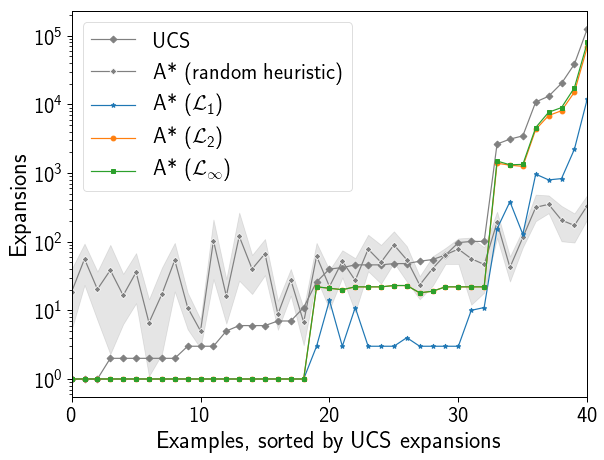

In [14]:
if HEURISTICS:
    fig, ax = plt.subplots()

    ax.plot(ucs_expansions, color='grey', label='UCS', marker=MARKERS[0])

    sns.lineplot(data=random_stats, x='datasetindex', y='expansions',
                 label='A* (random heuristic)', marker=MARKERS[0],
                 color='gray', linestyle='--', ax=ax)

    ax.plot(normal_expansions, label='A* ($\mathcal{L}_1$)', marker=MARKERS[1])
    ax.plot(l2_expansions, label='A* ($\mathcal{L}_2$)', marker=MARKERS[2])
    ax.plot(linf_expansions, label='A* ($\mathcal{L}_{\infty}$)', marker=MARKERS[3])

    ax.set_xlabel('Examples, sorted by UCS expansions')
    ax.set_ylabel('Expansions')
    ax.set_xlim(0, len(ucs_expansions) - 1)
    ax.set_yscale('log')
    ax.legend(loc='best')

    fig.set_figwidth(FIGWIDTH)
    fig.set_figheight(FIGHEIGHT)
    fig.set_tight_layout('tight')

    plt.show()

    if SAVE_PLOTS:
        save_fig(fig, 'bots__heuristics_expansions__bin_{}__band_{}__target_{}.pdf',
                 FOCUS_BINS, BAND, TARGET_CONFIDENCE)

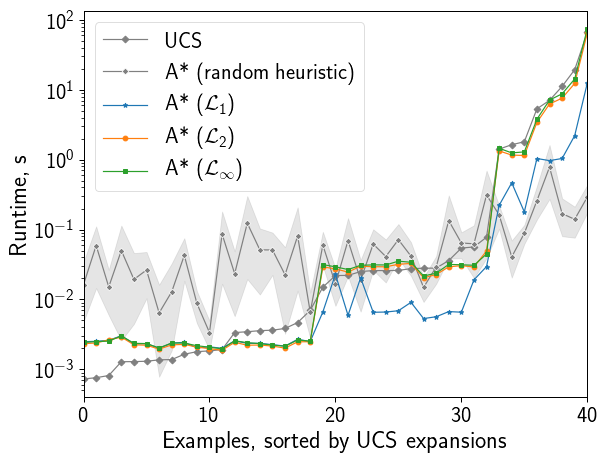

In [15]:
if HEURISTICS:
    fig, ax = plt.subplots()

    ax.plot(ucs_runtimes, label='UCS', marker=MARKERS[0], color='grey')

    sns.lineplot(data=random_stats, x='datasetindex', y='runtimes',
                 label='A* (random heuristic)', marker=MARKERS[0],
                 color='gray', linestyle='--', ax=ax)

    ax.plot(normal_runtimes, label='A* ($\mathcal{L}_1$)', marker=MARKERS[1])
    ax.plot(l2_runtimes, label='A* ($\mathcal{L}_2$)', marker=MARKERS[2])
    ax.plot(linf_runtimes, label='A* ($\mathcal{L}_{\infty}$)', marker=MARKERS[3])

    ax.set_xlabel('Examples, sorted by UCS expansions')
    ax.set_ylabel('Runtime, s')
    ax.set_xlim(0, len(ucs_expansions) - 1)
    ax.set_yscale('log')
    ax.legend(loc='best')

    fig.set_figwidth(FIGWIDTH)
    fig.set_figheight(FIGHEIGHT)
    fig.set_tight_layout('tight')

    plt.show()

    if SAVE_PLOTS:
        save_fig(fig, 'bots__heuristics_runtimes__bin_{}__band_{}__target_{}.pdf',
                 FOCUS_BINS, BAND, TARGET_CONFIDENCE)

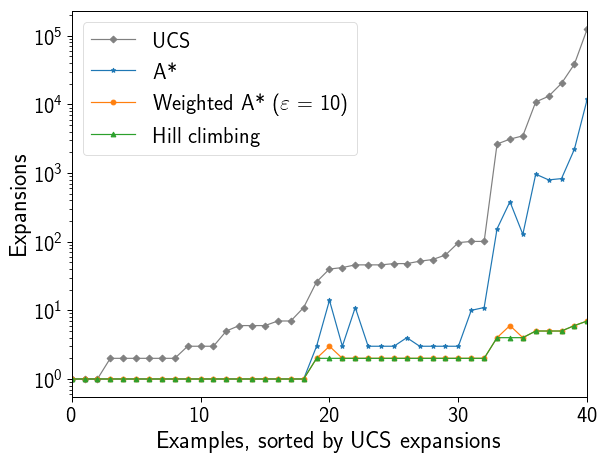

In [16]:
fig, ax = plt.subplots()

ax.plot(ucs_expansions, label='UCS', marker=MARKERS[0], color='grey')

ax.plot(normal_expansions, label='A*', marker=MARKERS[1])
ax.plot(high_eps_expansions, label='Weighted A* ($\\varepsilon$ = %i)' % HIGH_EPS, marker=MARKERS[2])
ax.plot(hill_expansions, label='Hill climbing', marker=MARKERS[4])

ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Expansions')
ax.set_xlim(0, len(ucs_expansions) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

plt.show()

if SAVE_PLOTS:
    save_fig(fig, 'bots__hill_climbing__expansions__bin_{}__band_{}__target_{}.pdf',
             FOCUS_BINS, BAND, TARGET_CONFIDENCE)

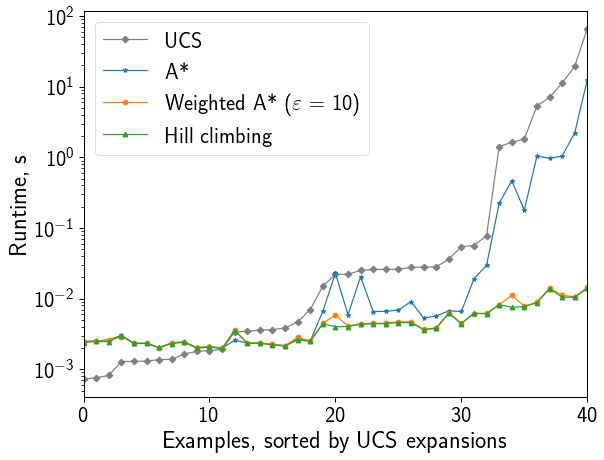

In [17]:
fig, ax = plt.subplots()

ax.plot(ucs_runtimes, label='UCS', marker=MARKERS[0], color='grey')

ax.plot(normal_runtimes, label='A*', marker=MARKERS[1])
ax.plot(high_eps_runtimes, label='Weighted A* ($\\varepsilon$ = %i)' % HIGH_EPS, marker=MARKERS[2])
ax.plot(hill_runtimes, label='Hill climbing', marker=MARKERS[4])

ax.set_xlabel('Examples, sorted by UCS expansions')
ax.set_ylabel('Runtime, s')
ax.set_xlim(0, len(ucs_expansions) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)
fig.set_tight_layout('tight')

plt.show()

if SAVE_PLOTS:
    save_fig(fig, 'bots__hill_climbing__runtimes__bin_{}__band_{}__target_{}.pdf',
             FOCUS_BINS, BAND, TARGET_CONFIDENCE)

Random heuristic costs

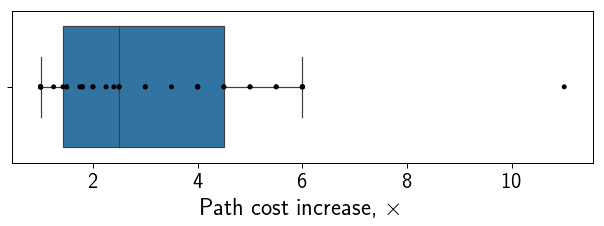

In [18]:
if HEURISTICS:
    random_results_data = random_results_data.sort_values('dataset_index')
    ucs_results_data = ucs_results_data.sort_values('dataset_index')
    assert random_results_data['dataset_index'].equals(ucs_results_data['dataset_index'])

    random_costs_df = pd.DataFrame(columns=['dataset_index', 'pathcostincrease'])
    random_costs_df.pathcostincrease = random_results_data.bench_cost / ucs_results_data.path_cost

    fig, ax = plt.subplots()

    sns.boxplot(data=random_costs_df, x='pathcostincrease', ax=ax, showfliers=False)
    sns.stripplot(data=random_costs_df, x='pathcostincrease', ax=ax, color='black', jitter=False)

    ax.set_xlabel(r'Path cost increase, $\times$')

    fig.set_figwidth(FIGWIDTH)
    fig.set_figheight(FIGHEIGHT / 2)
    fig.set_tight_layout('tight')


    if SAVE_PLOTS:
        save_fig(fig, 'bots__random_overhead__{}_band_{}__target_{}.pdf',
                 FOCUS_BINS, BAND, TARGET_CONFIDENCE)

Hill climbing costs

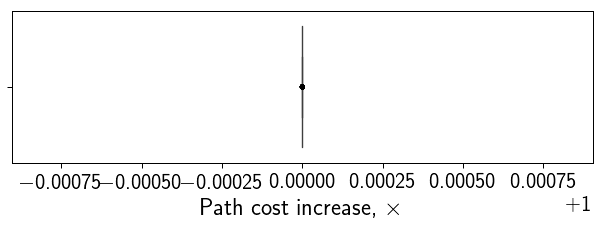

In [19]:
hill_results_data = hill_results_data.sort_values('dataset_index')
ucs_results_data = ucs_results_data.sort_values('dataset_index')
assert hill_results_data['dataset_index'].equals(ucs_results_data['dataset_index'])

hill_costs_df = pd.DataFrame(columns=['dataset_index', 'pathcostincrease'])
hill_costs_df.pathcostincrease = hill_results_data.path_cost / ucs_results_data.path_cost

fig, ax = plt.subplots()

sns.boxplot(data=hill_costs_df, x='pathcostincrease', ax=ax, showfliers=False)
sns.stripplot(data=hill_costs_df, x='pathcostincrease', ax=ax, color='black', jitter=False)

ax.set_xlabel(r'Path cost increase, $\times$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT / 2)
fig.set_tight_layout('tight')


if SAVE_PLOTS:
    save_fig(fig, 'bots__hill_climbing__overhead__bin_{}__band_{}__target_{}.pdf',
             FOCUS_BINS, BAND, TARGET_CONFIDENCE)